In [9]:
import numpy as np
import torch
import os.path as osp
from easydict import EasyDict
from model import BoundingBox3dV3QuantEulerNoRGB
from bbox3d_utils import depth2cloud, sample_bbox, quant_pc, quantile_box, masks_to_boxes, quaternions_to_rotmats, get_transforms_from_rotmats_and_translations
import matplotlib.pyplot as plt

MODEL_SNAPSHOT_PATH = '/Users/msieb/Downloads/model_itr_11000.pth'

DATASET_ROOT_DIR = '/Users/msieb/Downloads/eccv_dataset_2'
SPLIT_FOLDER = 'train'
SAMPLE_INDEX = 0
DEVICE = 'cpu'

TypeError: Invalid shape (3, 960, 1280) for image data

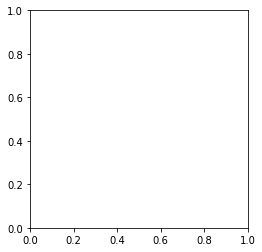

In [10]:
data_path = osp.join(DATASET_ROOT_DIR, SPLIT_FOLDER, '{:05d}'.format(SAMPLE_INDEX))
data = np.load(osp.join(data_path, 'data.npz'))
segm = np.load(osp.join(data_path, 'annotation/segm.npz'))

depth = torch.from_numpy(data['depth']).float().to(device=DEVICE)
intrinsic = torch.from_numpy(data['intrinsic']).float().to(device=DEVICE)
normals = torch.from_numpy(data['normals']).float().to(device=DEVICE)

rgb = torch.from_numpy(data['rgb']).to(device=DEVICE)
mask_occ = torch.from_numpy(segm['masks']).to(device=DEVICE)
mask_full = torch.from_numpy(segm['masks_amodal']).to(device=DEVICE)


plt.imshow(data['rgb'].transpose(1, 2, 0))

In [ ]:

cfg = EasyDict(
    DISTRIBUTED=False,
    QUANT_PARAMS=EasyDict(
        LENGTH=[0.0, 11.0, 512],
        OFFSET=[-8.0, 11.0, 512],
        EULER=[[0, np.pi * 2, 512], [0, np.pi, 512], [0, np.pi * 2, 512]],
        LENGTH_SLICE=slice(0, 3),
        OFFSET_SLICE=slice(3, 6),
        EULER_SLICE=slice(6, 9),
    ),

    EPOCHS=1000,
    STEPS_PER_TRAIN_EPOCH=100,
    STEPS_PER_VAL_EPOCH=25,
    SNAPSHOT_EVERY=500,
)
model = BoundingBox3dV3QuantEulerNoRGB(cfg).to(device=DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


In [ ]:
state_dict = {}
for k, v in torch.load(MODEL_SNAPSHOT_PATH, map_location=torch.device('cpu'))['model'].items():
    k = k.replace('._', '.')
    state_dict[k[13:]] = v
model.load_state_dict(state_dict)



<All keys matched successfully>

In [ ]:

point_cloud = depth2cloud(depth, intrinsic, rgb.shape[-2], rgb.shape[-1])[0].transpose(2, 1).transpose(1, 0)
mask_full_sum = mask_full.float().sum(dim=(1, 2))
occ_ratio = 1 - mask_occ.float().sum(dim=(1, 2)) / mask_full_sum
model_inputs = dict(
    rgbs=None,
    im_size=torch.tensor([rgb.shape[-2], rgb.shape[-1]]).to(device=DEVICE),
    point_cloud=point_cloud,
    normals_pred=normals,
    boxes=masks_to_boxes(mask_full)[occ_ratio < 0.9],
    segm_feats=None,
    depth_feats=None,
    mask_occ=mask_occ[occ_ratio < 0.9],
    mask_full=mask_full[occ_ratio < 0.9],
    depth_valid=torch.ones_like(depth),
    depth_uncertainty=torch.ones_like(depth),
    occ_ratio=occ_ratio,
    bin_probs=torch.zeros(rgb.shape[-2], rgb.shape[-1]).to(device=DEVICE)
)
blobs = model.predict(
    **model_inputs
)
lengths, pos, quat, ent, logps = sample_bbox(
    blobs['feats'],
    blobs['ranges_patches'],
    blobs['means_patches'],
    64,
    "random",
    model.quant_order,
    model.autoreg,
    model.length_slice,
    model.offset_slice,
    model.euler_slice,
)
all_points, mean_inter, quat =  quant_pc(lengths, quat, pos, grid_size=4)
out = quantile_box(all_points, mean_inter, quat, quantile=0.2)
valids = (
    torch.isfinite(out["dim"]).all(-1)
    & torch.isfinite(out["position"]).all(-1)
    & torch.isfinite(out["quat"]).all(-1)
)


In [ ]:
from scene_builder import SceneBuilder, BatchBBox3D

boxes = BatchBBox3D(dimensions=out['dim'], poses=get_transforms_from_rotmats_and_translations(
                    rotmats=quaternions_to_rotmats(out["quat"]), translations=out["position"]
                ),valids=valids)
builder = SceneBuilder.from_point_map(
    depth2cloud(depth, intrinsic, rgb.shape[-2], rgb.shape[-1])[0], rgb.float(), flip_xz=True, size=2e-3, render_size=(480, 320)
)
builder.add_bbox3d_batch(boxes)


/usr/local/lib/python3.9/site-packages/pythreejs/traits.py:203: UserWarning: 64-bit data types not supported for WebGL data, casting to 32-bit.
  warnings.warn('64-bit data types not supported for WebGL '
/usr/local/lib/python3.9/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(aspect=1.5, fov=90.0, position=(-0.04380445459756456, 1.2506322571971074, -0…